## Interpreting indoor positioning as neural machine translation (NMT) problem

This repository is meant as final project after having attended CS224N (Deep Learning for Natural Language Processing).
Instead of targeting a dedicated NLP problem, the goal of this project is to apply the learned ideas to a different domain - indoor positioning.

### Introduction to indoor positioning
Since GNSS positioning (known from outdoors) does not work within buildings, identifying alternative localization methods has been a research subject over the last couple of years. The field recently received new momentum, since deep learning based approaches have become the goto standard for tackling several open questions in the field, including WLAN fingerprinting (static absolute positioning), directly inferring relative position changes from inertial measurement units (IMU) instead of applying conventional dead reckoning, and many others.

Most accurate positioning can be achieved by fusing several methods, especially those that deliver absolute position estimates (probably at a lower sampling frequency) with the ones that provide relative position updates (obtained at a much higher sampling frequency). Common candidates for absolute estimates are fingerprinting based approaches. Given a set of previously collected fingerprints labeled with the position of collection, a model can be trained in a supervised setting to predict the position for unseen fingerprints. A fingerprint is defined as the observable sensor information, which in case of WLAN fingerprinting is often defined as the received signal strength (RSS) to all observable access points at the given location.

In contrast, relative positioning can be achieved via the IMU (installed in all smartphones). By detecting steps and direction changes, a pedestrian dead reckoning method can be implemented. Recently, it has been demonstrated that via deep learning relative position updates can be directly learned from labeled IMU data.

A common challenge remains to fuse absolute and relative estimates, which is traditionally done via state estimation models (e.g. Kalman filter or Particle Filter).

In this experimentally oriented work, we try to interpret the problem from the perspective of neural machine translation.

### Model definition
We regard a sequence of IMU measurements and a sequence of WLAN fingerprints as source sentences (of fixed length), which we try to translate into a sequence of position estimates. This allows for modelling the problem via an NLP sequence based encoder/decoder model. We define a sequence of IMU measurements of size T as $\mathbf{X} = (\mathbf{x}_1,...,\mathbf{x}_T)$, where each $\mathbf{x}_i \in \mathbb{R}^6$ contains 3-dimensional accelerometer, gyroscope measurements and $\mathbf{X} \in \mathbb{R}^{T\times 6}$. Further, we define the matching target sequence of fixed length O as $\mathbf{Y} \in \mathbb{R}^{O \times 2}$, which holds the coordinates at the O sample locations of the sequence.

Within such a sequence of T IMU measurements, we assume to have observed M fingerprints (M might differ from sequence to sequence, since the sampling frequency is not fixed in contrast to IMU). A fingerprint is defined as $\mathbf{f} = (RSS_1, ..., RSS_A)$ where $RSS_i$ is the received signal strength (RSS) to the i-th access point. Note that the mapping from indices to APs is fixed and A represents the total amount of observed APs within the dataset.
We synchronize the WLAN fingerprints in time domain with the IMU sequence and forward fill the RSS values between consecutive scans to avoid sparseness. The resulting sequence of WLAN fingerprints is given as $\mathbf{F} \in \mathbb{R}^{T\times A}$.

We utilize an LSTM encoder to process both input sequences. The fingerprint sequence is processed with a time-distributed dense layer prior to concatenating it with the IMU input and feeding it to the LSTM layer. The idea is that absolute location is injected by the processed WLAN fingerprint at each encoding step of the LSTM unit, while relative information is obtained via the raw IMU input.

The weights of time-distributed RSS input processing layer are given as $\mathbf{W}_F \in \mathbb{R}^{h \times A}$, such that for the i-th step of the input sequence we obtain its hidden representation as
$$\mathbf{o}_i = \mathbf{W}_F \mathbf{F}_i$$ where $\mathbf{o}_i \in \mathbb{R}^{h \times 1}$.

The input at the i-th encoding step of the sequence is then given as
$$\mathbf{e}_i = [\mathbf{X}_i, \mathbf{o}_i] \in \mathbb{R}^{6+A \times 1}$$

Let $\mathbf{h}_T^{enc}$ and $\mathbf{c}_T^{enc}$ be the final hidden states of the decoder, we then initialize the decoder with those and apply the decoder as
$$\mathbf{h}^{dec}_t, \mathbf{c}^{dec}_t = Decoder(\overline{\mathbf{Y}_t}, \mathbf{h}^{dec}_{t-1}, \mathbf{c}^{dec}_{t-1})$$

Note that the during training we feed the original target sequence as input to the decoder to train the model in teacher-forced setting. The same sequence shifted by one time step is used as ground truth to compute the loss over the predicted output sequence. During prediction, we utilize the previous decoder output as input for the next decoding step. Those differences can be seemingly implemented by model subclassing as shown in the repository.

Finally, we also implemented cross-attention to the encoder hidden states when decoding the encoded sequence. Note that while this is especially important in natural language translation, where not exactly each source word position matches the target word position, in our setting there is a strict temporal correspondence between input and output sequence, such that attention is assumed to have a neglectable impact. We utilize simple dot-product attention as defined

$$\mathbf{e}_{t,i} = (\mathbf{h}^{dec}_t$)^T\mathbf{h}^{enc}_i \text{ where } \mathbf{e}_t \in \mathbb{R}^{T \times 1}$$
$$\alpha_t = softmax(\mathbf{e}_t) \text{ where } \alpha_t \in \mathbb{R}^{T \times 1}$$
$$\mathbf{a}_t = \sum_{i=1}^T \alpha_{t,i}\mathbf{h}^{enc}_i \text{ where } \mathbf{a}_t \in \mathbb{R}^{h\times 1}$$

Depending on whether attention is used we utilize a final transformation layer that receives
$$\mathbf{u}_t = \begin{cases} [\mathbf{a}_t;\mathbf{h}_t^{dec}] & \text{ if attention is used} \\ \mathbf{h}_t^{dec} & \text{ else}\end{cases}$$

and transforms it as
$$\mathbf{v}_t = \mathbf{W}_h \mathbf{u}_t$$ where $\mathbf{W}_h \in \mathbb{R}^{h|2h \times h}$

Finally, we compute a linear transformation of the combined output to obtain the target prediction (coordinates) at step t as
$$\mathbf{o}_t = \mathbf{W}_{target}\mathbf{v}_t \text{ where } \mathbf{o}_t \in \mathbb{R}^{2 \times 1}, \mathbf{W}_{target} \in \mathbb{R}^{2 \times h}$$



#### Network training
The network can be trained by using standard mean squared error loss.
Additionally, we experimented with a custom loss function that also penalizes the relative changes among the predicted trajectory with respect to the target trajectory.

The relative changes are computed as follows. Given $(\mathbf{y}_i; ...; \mathbf{y}_{i+1})$ and $(\mathbf{p}_i; ..., \mathbf{p}_{i+1})$, we move the initial point to the origin to obtain the vectors $\mathbf{p}_{i\rightarrow i+1} = \mathbf{p}_{i+1} - \mathbf{p}_i$ and $\mathbf{y}_{i\rightarrow i+1} = \mathbf{y}_{i+1} - \mathbf{y}_i$.
We the compute the dot product between those vectors $d_{i\rightarrow i+1} = (\mathbf{p}_{i\rightarrow i+1})^T \mathbf{y}_{i\rightarrow i+1}$ to capture angular and the magnitudal differences. We then obtain the combined loss as
$$\mathcal{L} = -\sum_{i=1}^{O-1} d_{i\rightarrow i+1} + MSE(\mathbf{Y} - \mathbf{P})$$

#### Dataset

We utilize the [giaIndoorLoc](https://doi.org/10.5281/zenodo.6801310) dataset for training our model. The dataset contains several trajectories of collected data that include the WLAN fingerprints (with roughly 3-5s between consecutive samples) and IMU measurements every 20ms. Each data entry is labeled with the true position of collection. We use T=200, such that M $\in$ [0,3]. We utilize padded tensors for modelling the variable sequence length M. The target output length is set to 0=10 and we artificially enlarge our dataset by generating step-wise (10) shift for obtaining the various input/output sequences.

### PyTorch: Example of training the model and generating a few predictions

In [15]:
from dataset import Seq2SeqDataset
from model_pt import NMTindoorLocPT
import numpy as np
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import pandas as pd

# disable pandas warning
pd.options.mode.chained_assignment = None

from visualization import visualize_predictions

In [16]:
print("Prepare input data...")
training_loader = torch.utils.data.DataLoader(Seq2SeqDataset(devices=['S20', 'Galaxy', 'OnePlus'], train=True, num_imu_channels=6, transform=torch.Tensor), batch_size=32, shuffle=True)

Prepare input data...
Deleted 0.0 % of data due to missing RSS readings in windows


In [17]:
print("Setup model...")
# construct PyTorch model
model = NMTindoorLocPT(hidden_size=256, num_imu=6, num_ap=np.shape(training_loader.dataset.rss)[-1])

loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Setup model...


In [18]:
print("Define training loop...")
def train_one_epoch():

    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

    return loss

Define training loop...


In [19]:
# activate training model for teacher-forced setting
model.train(True)

for epoch in range(10):
    print('EPOCH {}:'.format(epoch + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    avg_loss = train_one_epoch()

    print('LOSS train {}'.format(avg_loss))

EPOCH 1:
LOSS train 157.89683532714844
EPOCH 2:
LOSS train 81.6717758178711
EPOCH 3:
LOSS train 20.676137924194336
EPOCH 4:
LOSS train 15.140612602233887
EPOCH 5:
LOSS train 8.216609954833984
EPOCH 6:
LOSS train 2.8735034465789795
EPOCH 7:
LOSS train 3.1501574516296387
EPOCH 8:
LOSS train 1.3880022764205933
EPOCH 9:
LOSS train 1.1494694948196411
EPOCH 10:
LOSS train 1.250320553779602


Deleted 0.0 % of data due to missing RSS readings in windows
Regular mean error: 2.4949575057082582


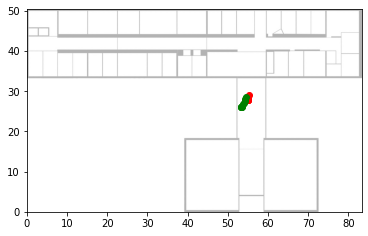

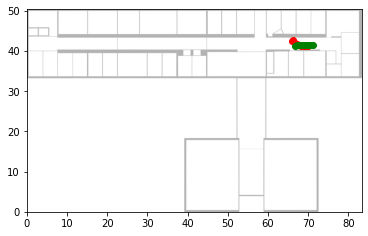

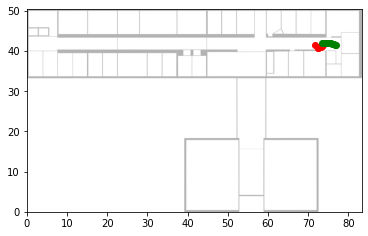

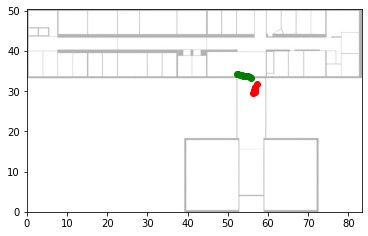

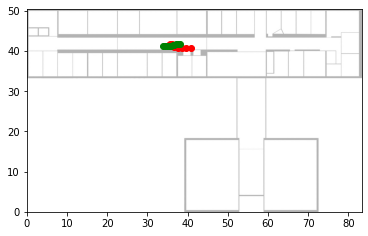

In [21]:
# sample random sequence of test indices
test_ds = Seq2SeqDataset(devices=['S20', 'Galaxy', 'OnePlus'], train=False, num_imu_channels=6)
s_idx = np.random.choice(np.arange(len(test_ds.imu)), len(test_ds.imu), replace=False)

# predict sequences with learned model (uses prior pos prediction as next input of decoder)
model.train(False)
pred_seq = model.predict([torch.Tensor(test_ds.imu[s_idx[:]]), torch.Tensor(test_ds.rss[s_idx[:]])])
true_seq = test_ds.pos_target[s_idx, :, :]
pred_seq = pred_seq.detach().numpy()

print("Regular mean error: {}".format(np.mean(np.linalg.norm(true_seq - pred_seq, axis=-1))))

visualize_predictions(true_seq[:5], pred_seq[:5])

#### Results

This project only servers as a proof of concept for applying neural machine translation models for sequential indoor positioning and for strengthening the understanding of current NLP models. Therefore, we do not provide a formal evaluation and comparison of the developed models. We note that any model having a separate encoder for the WLAN fingerprints is capable of extracting the absolute position via the fingerprint decoder, however, there are still problems in the decoding shape of the trajectory. It should be able to capture the shape through the movement relatively encoded within the IMU decoder hidden states, which is currently not always achieved. Furthermore, the model has trouble to extract the absolute position from the WLAN encoder hidden state. The loss will stagnate at the state where the model always outputs the mean position. However, eventually it often finds a way to further decrease the loss but this is not always guaranteed.

### Tensorflow implementation example

In [22]:
from data_provider import get_joint_source_data, scale_imu_data
from sklearn.model_selection import train_test_split
import numpy as np
from model_tf import NMTindoorLoc
import tensorflow as tf
from visualization import visualize_predictions

# disable pandas warning
pd.options.mode.chained_assignment = None

In [23]:
data, pos = get_joint_source_data(devices=['S20', 'Galaxy', 'OnePlus'],
                                  return_unique_fp_for_sequence=False,
                                  forward_fill_scans=True,
                                  seq_to_point=False,
                                  add_start_token=True,
                                  include_mag=False)

num_imu_channels = 6

# decouple input data
imu = data[:, :, :num_imu_channels]
rss = data[:, :, num_imu_channels:]

# imu and pos data dimensions
_, T_pos, _ = np.shape(pos)

# scale imu data
imu = scale_imu_data(imu)

# scale rss data
max_rss = -40.0
min_rss = -110.0
rss = (rss - min_rss) / (max_rss - min_rss)

# split into train/test data
imu_train, imu_test, rss_train, rss_test, pos_train, pos_test = train_test_split(imu, rss, pos, test_size=0.2, random_state=1, shuffle=True)

# Prepare position data for teacher forced sequence prediction (target will be offset by 1)
dec_init = pos_train[:, :-1, :]
dec_target = pos_train[:, 1:, :]

Deleted 0.0 % of data due to missing RSS readings in windows


In [24]:
# model parameters
model_name = 'tf_model'

# construct tensorflow model and compile
model = NMTindoorLoc(hidden_size=256, cross_attention=False, bidirectional_encoder=False)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanSquaredError()
)

history = model.fit(
    (imu_train, rss_train, dec_init),
    dec_target,
    batch_size=32,
    epochs=20,
)

model.save_weights(model_name + ".hdf5")

Metal device set to: Apple M1 Pro


2022-08-02 11:43:24.186345: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-02 11:43:24.187340: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2022-08-02 11:43:26.564474: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-02 11:43:28.040541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-02 11:43:28.269341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-02 11:43:28.601343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-02 11:43:28.694176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-02 11:43:28.774408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


245/245 [==============================] - 20s 71ms/step - loss: 464.8432
Epoch 2/20
245/245 [==============================] - 17s 68ms/step - loss: 61.9040
Epoch 3/20
245/245 [==============================] - 17s 68ms/step - loss: 15.1299
Epoch 4/20
245/245 [==============================] - 17s 67ms/step - loss: 5.5691
Epoch 5/20
245/245 [==============================] - 16s 67ms/step - loss: 3.2617
Epoch 6/20
245/245 [==============================] - 16s 67ms/step - loss: 2.1615
Epoch 7/20
245/245 [==============================] - 17s 68ms/step - loss: 1.6198
Epoch 8/20
245/245 [==============================] - 16s 67ms/step - loss: 1.4919
Epoch 9/20
245/245 [==============================] - 16s 67ms/step - loss: 1.3086
Epoch 10/20
245/245 [==============================] - 16s 67ms/step - loss: 1.1041
Epoch 11/20
245/245 [==============================] - 16s 67ms/step - loss: 0.8772
Epoch 12/20
245/245 [==============================] - 16s 67ms/step - loss: 0.7230
Epoch 13

Regular mean error: 2.674337128474294


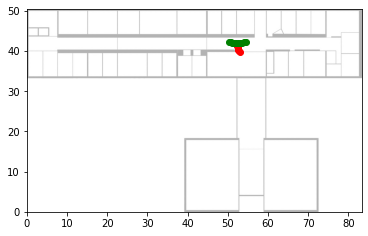

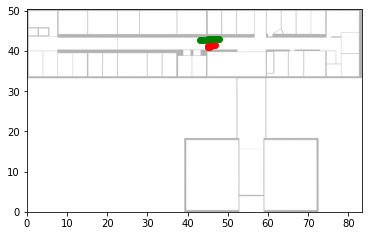

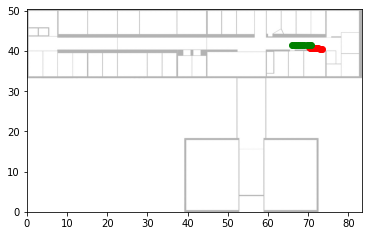

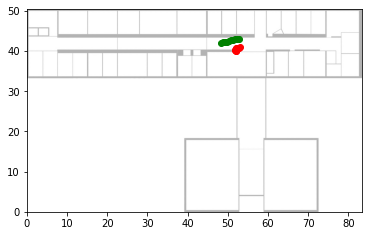

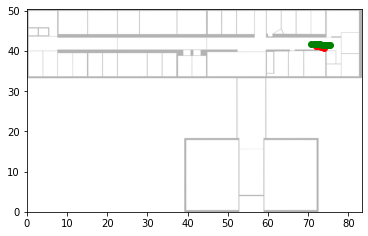

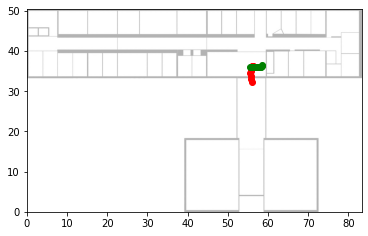

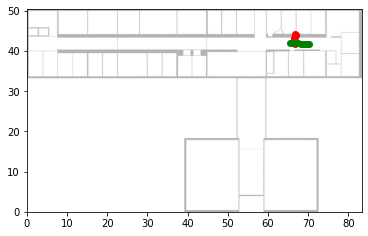

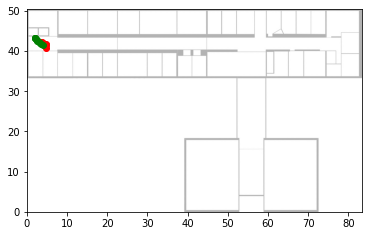

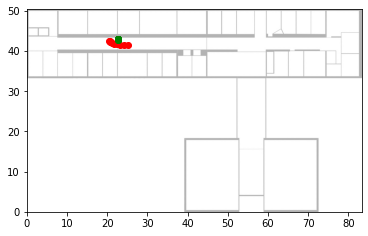

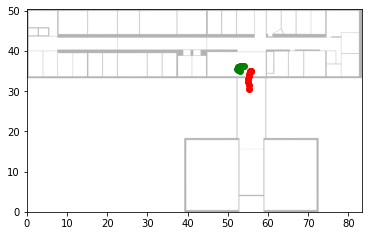

In [12]:
# reload trained model weights
model.load_weights(model_name + ".hdf5")

# sample random sequence of test indices
s_idx = np.random.choice(np.arange(len(imu_test)), len(imu_test), replace=False)

# predict sequences with learned model (uses prior pos prediction as next input of decoder)
pred_seq = model.predict([imu_test[s_idx], rss_test[s_idx]])
true_seq = pos_test[s_idx, 1:, :]

print("Regular mean error: {}".format(np.mean(np.linalg.norm(true_seq - pred_seq, axis=-1))))

visualize_predictions(pos_test[s_idx[:10], 1:, :], pred_seq[:10])

#### Alternative implementations

We have implemented various variations of the model architecture. Initially we merged both input data sources by extending the fingerprints in the time-domain. This allows for using a single encoder on the joint input data. However, the sparseness in the time domain prevents the model from properly extracting the global location from the fingerprints. Furthermore, since the number of fingerprints per sequence is quite small, we tried to map it into a single fingerprint by utilizing the most recent RSS value for APs observed multiple time during the sequence. We also implemented a baseline method to check whether the absolute position can be extracted from the fingerprints only.

### Acknowledgements

The code and the model architecture of the encoder/decoder model (LSTM with attention) is heavily inspired by assignment 4 of CS224n.